In [1]:
# get necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model as lm
from sklearn import preprocessing as pp
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

D:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#read the data and view first 5 rows
data = pd.read_csv('Downloads\oec.csv')
data.head()

,PlanetIdentifier,TypeFlag,PlanetaryMassJpt,RadiusJpt,PeriodDays,SemiMajorAxisAU,Eccentricity,PeriastronDeg,LongitudeDeg,AscendingNodeDeg,...,DiscoveryYear,LastUpdated,RightAscension,Declination,DistFromSunParsec,HostStarMassSlrMass,HostStarRadiusSlrRad,HostStarMetallicity,HostStarTempK,HostStarAgeGyr
0,KOI-1843.03,0,0.0014,0.054,0.176891,0.0048,NaN,NaN,NaN,NaN,...,2012.0,13/07/15,19 00 03.14,+40 13 14.7,NaN,0.46,0.45,0.00,3584.0,NaN
1,KOI-1843.01,0,NaN,0.114,4.194525,0.0390,NaN,NaN,NaN,NaN,...,NaN,NaN,19 00 03.14,+40 13 14.7,NaN,0.46,0.45,0.00,3584.0,NaN
2,KOI-1843.02,0,NaN,0.071,6.356006,0.0520,NaN,NaN,NaN,NaN,...,NaN,NaN,19 00 03.14,+40 13 14.7,NaN,0.46,0.45,0.00,3584.0,NaN
3,Kepler-9 b,0,0.2500,0.840,19.224180,0.1430,0.0626,NaN,NaN,NaN,...,2010.0,15/12/03,19 02 17,+38 24 03,650.0,1.07,1.02,0.12,5777.0,NaN
4,Kepler-9 c,0,0.1700,0.820,39.031060,0.2290,0.0684,NaN,NaN,NaN,...,2010.0,15/12/03,19 02 17,+38 24 03,650.0,1.07,1.02,0.12,5777.0,NaN


In [3]:
data.shape

(3426, 24)

In [4]:
data.info() #here we can see how many missing values we have for each attribute

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3426 entries, 0 to 3425
Data columns (total 24 columns):
PlanetIdentifier        3426 non-null object
TypeFlag                3426 non-null int64
PlanetaryMassJpt        1176 non-null float64
RadiusJpt               2670 non-null float64
PeriodDays              3341 non-null float64
SemiMajorAxisAU         1271 non-null float64
Eccentricity            1003 non-null float64
PeriastronDeg           295 non-null float64
LongitudeDeg            39 non-null float64
AscendingNodeDeg        46 non-null float64
InclinationDeg          568 non-null float64
SurfaceTempK            733 non-null float64
AgeGyr                  1 non-null float64
DiscoveryMethod         3416 non-null object
DiscoveryYear           3416 non-null float64
LastUpdated             3418 non-null object
RightAscension          3416 non-null object
Declination             3416 non-null object
DistFromSunParsec       2018 non-null float64
HostStarMassSlrMass     3262 non-nul

Here I have to decide how to deal with missing values. One idea is to use some prior knowledge. My first thought is that a planet's mass and radius are correlated, so I will test that. I will do the same with stars.

In [5]:
#we select the attributes we want to focus on, mostly those with few missing values
attributes = ['PlanetIdentifier', 'TypeFlag', 'PlanetaryMassJpt', 
              'RadiusJpt', 'PeriodDays', 'SemiMajorAxisAU', 'Eccentricity', 'DistFromSunParsec',
              'HostStarMassSlrMass', 'HostStarRadiusSlrRad'] 

#we're gonna use these 2 attributes to find out if there is correlation between a planet's mass and radius
planetAttributes = ['PlanetaryMassJpt','RadiusJpt'] 

#same with stars
starAttributes = ['HostStarMassSlrMass', 'HostStarRadiusSlrRad']

In [6]:
planetData = data[planetAttributes].dropna() #we select the not-na entries for planets

planetData.info() #that gives us 435 rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435 entries, 0 to 3419
Data columns (total 2 columns):
PlanetaryMassJpt    435 non-null float64
RadiusJpt           435 non-null float64
dtypes: float64(2)
memory usage: 10.2 KB


In [7]:
starData = data[starAttributes].dropna() #same with stars, but we get way more rows

starData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3039 entries, 0 to 3425
Data columns (total 2 columns):
HostStarMassSlrMass     3039 non-null float64
HostStarRadiusSlrRad    3039 non-null float64
dtypes: float64(2)
memory usage: 71.2 KB


Text(0, 0.5, 'Planet Radius(Jupiter Radius)')

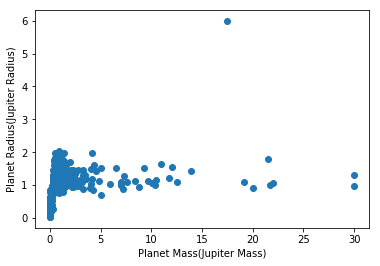

In [8]:
x1 = planetData['PlanetaryMassJpt'] 
y1 = planetData['RadiusJpt']

plt.scatter(x1,y1) #testing my intuition that a planet's mass and radius are strongly correlated by looking at a scatter plot
plt.xlabel('Planet Mass(Jupiter Mass)')
plt.ylabel('Planet Radius(Jupiter Radius)')

In [9]:
# I also use linear regression to get an exact number (0 means no correlation, 1 means perfect correlation)
planetmodel = lm.LinearRegression()
planetmodel.fit(planetData.PlanetaryMassJpt.values.reshape(-1,1), planetData.RadiusJpt.values.reshape(-1,1))
planetmodel.score(planetData.PlanetaryMassJpt.values.reshape(-1,1), planetData.RadiusJpt.values.reshape(-1,1))

0.09504722523461462

Turns out that a planet's mass and radius are not strongly correlated

Text(0, 0.5, 'Star Radius(Solar Radius)')

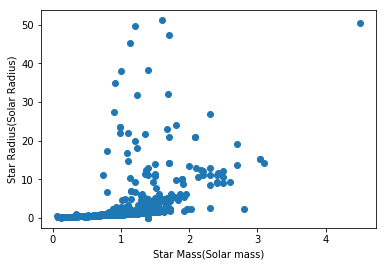

In [10]:
x2 = starData['HostStarMassSlrMass']
y2 = starData['HostStarRadiusSlrRad']

plt.scatter(x2,y2) #same with stars
plt.xlabel('Star Mass(Solar mass)')
plt.ylabel('Star Radius(Solar Radius)')

While there are spots where it indicates there is a correlation, it is not as strong as we would like. We are going to use regression to get an exact measure of correlation:

In [11]:
starmodel = lm.LinearRegression()
starmodel.fit(starData.HostStarMassSlrMass.values.reshape(-1,1), starData.HostStarRadiusSlrRad.values.reshape(-1,1))
starmodel.score(starData.HostStarMassSlrMass.values.reshape(-1,1), starData.HostStarRadiusSlrRad.values.reshape(-1,1))

0.1973954319481086

We can safely conclude that in both cases, mass and radius are not strongly correlated. In this case, we can either drop all rows with missing values, or we can use the average of the column to replace them with. We will do the latter.

#  Pre-processing

In [12]:
newData = data.fillna(data.mean())

In [13]:
# now we have values for all 
newData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3426 entries, 0 to 3425
Data columns (total 24 columns):
PlanetIdentifier        3426 non-null object
TypeFlag                3426 non-null int64
PlanetaryMassJpt        3426 non-null float64
RadiusJpt               3426 non-null float64
PeriodDays              3426 non-null float64
SemiMajorAxisAU         3426 non-null float64
Eccentricity            3426 non-null float64
PeriastronDeg           3426 non-null float64
LongitudeDeg            3426 non-null float64
AscendingNodeDeg        3426 non-null float64
InclinationDeg          3426 non-null float64
SurfaceTempK            3426 non-null float64
AgeGyr                  3426 non-null float64
DiscoveryMethod         3416 non-null object
DiscoveryYear           3426 non-null float64
LastUpdated             3418 non-null object
RightAscension          3416 non-null object
Declination             3416 non-null object
DistFromSunParsec       3426 non-null float64
HostStarMassSlrMass     34

In [14]:
newData.describe()

,TypeFlag,PlanetaryMassJpt,RadiusJpt,PeriodDays,SemiMajorAxisAU,Eccentricity,PeriastronDeg,LongitudeDeg,AscendingNodeDeg,InclinationDeg,SurfaceTempK,AgeGyr,DiscoveryYear,DistFromSunParsec,HostStarMassSlrMass,HostStarRadiusSlrRad,HostStarMetallicity,HostStarTempK,HostStarAgeGyr
count,3426.000000,3426.000000,3426.000000,3426.000000,3426.000000,3426.000000,3426.000000,3426.000000,3426.000000,3426.000000,3426.000000,3.426000e+03,3426.000000,3426.000000,3426.000000,3426.000000,3426.000000,3426.000000,3426.000000
mean,0.098657,2.939151,0.347422,550.487202,1.410090,0.169331,147.296127,145.124011,90.624476,82.336692,865.544748,5.500000e-03,2013.179450,549.986784,0.981646,1.488426,0.014637,5510.861552,4.629284
std,0.425691,6.138908,0.345273,7572.481012,3.967928,0.104439,34.801301,13.499063,10.665540,9.379098,310.145709,2.602465e-17,6.259101,616.452170,0.304873,2.959168,0.160674,1191.448899,1.154477
min,0.000000,0.000008,0.002300,0.090706,0.004420,0.000000,-233.000000,-174.640000,-5.112604,-0.000543,102.200000,5.500000e-03,1781.000000,1.341700,0.012000,0.000014,-2.090000,540.000000,0.002200
25%,0.000000,2.292500,0.154940,5.068135,0.871250,0.169331,147.296127,145.124011,90.624476,82.336692,865.544748,5.500000e-03,2012.000000,241.740000,0.840000,0.826000,-0.010000,5148.000000,4.629284
50%,0.000000,2.939151,0.245650,14.017238,1.410090,0.169331,147.296127,145.124011,90.624476,82.336692,865.544748,5.500000e-03,2014.000000,549.986784,0.981646,1.020000,0.014637,5602.500000,4.629284
75%,0.000000,2.939151,0.347422,56.667278,1.410090,0.169331,147.296127,145.124011,90.624476,82.336692,865.544748,5.500000e-03,2016.000000,549.986784,1.090000,1.359750,0.050000,5930.500000,4.629284
max,3.000000,263.000000,6.000000,320000.000000,177.000000,0.956000,791.000000,333.000000,320.800000,305.000000,7112.000000,5.500000e-03,2016.000000,8500.000000,4.500000,51.100000,0.560000,29300.000000,13.900000


In [15]:
# now we get the attributes we want to work with, and get rid of unneccesary ones, like discovery year
newData = newData[attributes]

In [16]:
train_set = newData[:2740] #create a training and a testing set
test_set = newData[2741:]
train_set.shape #double check

(2740, 10)

In [17]:
test_set.shape

(685, 10)

In [18]:
train_set = train_set.drop(['PlanetIdentifier'], axis = 1) # this attribute does not contribute to the training, as it is just an ID column
test_set = test_set.drop(['TypeFlag'], axis = 1) # we remove the target variable from the test set
train_set.head()

,TypeFlag,PlanetaryMassJpt,RadiusJpt,PeriodDays,SemiMajorAxisAU,Eccentricity,DistFromSunParsec,HostStarMassSlrMass,HostStarRadiusSlrRad
0,0,0.001400,0.054,0.176891,0.0048,0.169331,549.986784,0.46,0.45
1,0,2.939151,0.114,4.194525,0.0390,0.169331,549.986784,0.46,0.45
2,0,2.939151,0.071,6.356006,0.0520,0.169331,549.986784,0.46,0.45
3,0,0.250000,0.840,19.224180,0.1430,0.062600,650.000000,1.07,1.02
4,0,0.170000,0.820,39.031060,0.2290,0.068400,650.000000,1.07,1.02


In [19]:
X_train = train_set.drop("TypeFlag", axis=1) # we separate the target variable form the training set
Y_train = train_set["TypeFlag"]
X_test  = test_set.drop("PlanetIdentifier", axis=1).copy()
X_test.head()

,PlanetaryMassJpt,RadiusJpt,PeriodDays,SemiMajorAxisAU,Eccentricity,DistFromSunParsec,HostStarMassSlrMass,HostStarRadiusSlrRad
2741,1.814000,0.347422,4205.800000,5.23500,0.098500,15.300000,1.08,1.245000
2742,2.939151,0.254000,51.079263,1.41009,0.169331,549.986784,1.04,1.050000
2743,2.939151,0.112000,3.709214,1.41009,0.169331,549.986784,1.04,1.050000
2744,0.066000,0.347422,550.487202,1.41009,0.169331,3300.000000,0.38,1.488426
2745,2.939151,0.207000,11.085076,1.41009,0.169331,549.986784,0.80,0.760000


And now we can try different classifiers

In [20]:
# stochastic gradient descent (SGD) learning
sgd = lm.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)

Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)


print(round(acc_sgd,2,), "%")

85.69 %


In [21]:
# random forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

100.0 %


In [22]:
# logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
print(round(acc_log,2,), "%")

94.74 %


In [23]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)

acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
print(round(acc_knn,2,), "%")

95.77 %


In [24]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)

Y_pred = gaussian.predict(X_test)

acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
print(round(acc_gaussian,2,), "%")

92.74 %


In [25]:
# Perceptron
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, Y_train)

Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
print(round(acc_perceptron,2,), "%")

94.85 %


In [26]:
# Linear SVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
print(round(acc_linear_svc,2,), "%")

91.2 %


In [27]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

Y_pred = decision_tree.predict(X_test)

acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print(round(acc_decision_tree,2,), "%")

100.0 %


In [28]:
# table of classification results
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
100.00,Random Forest
100.00,Decision Tree
95.77,KNN
94.85,Perceptron
94.74,Logistic Regression
92.74,Naive Bayes
91.20,Support Vector Machines
85.69,Stochastic Gradient Decent


Now we will try K-fold cross validation on the dataset, and see how the random forest classifier works there.

In [29]:
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [30]:
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.94202899 0.94927536 0.95272727 0.94890511 0.94890511 0.95255474
 0.95970696 0.95238095 0.95970696 0.94852941]
Mean: 0.9514720867616587
Standard Deviation: 0.005050106746981076


The average accuracy of the model is 95%, and its deviation is miniscule, almost 0.01%

Now we will illustrate the attributes and their importance to the classification results

In [31]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
DistFromSunParsec,0.186
HostStarMassSlrMass,0.146
SemiMajorAxisAU,0.145
PlanetaryMassJpt,0.123
PeriodDays,0.115
HostStarRadiusSlrRad,0.110
Eccentricity,0.096
RadiusJpt,0.079


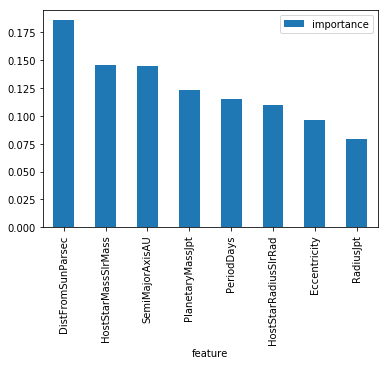

In [32]:
importances.plot.bar()

In [33]:
#we will drop the least important features and test the model again
train_set  = train_set.drop("Eccentricity", axis=1)
test_set  = test_set.drop("Eccentricity", axis=1)

train_set  = train_set.drop("RadiusJpt", axis=1)
test_set  = test_set.drop("RadiusJpt", axis=1)

In [34]:
random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

100.0 %


We see that the Random Forest classifier still has an impressive 100% accuracy. This is slightly suspicious and could use further validation and tests. As further work, synthetic data could be used to test the calssifiers again.